# ITCS 6010: Assignment #2 (V1)

<font color="red">(Due: 11 pm on Nov 12th) </font>

### 1. In the middle of P125, the red line in the left figure shows that the first episode results in a change in only $V(A)$. What does this tell you about what happened on the first episode? Why was only the estimate for this one state changed? By exactly how much was it changed? 

<img src="images/HW2_Q1.jpg" title="Q1" />

### 2. Draw the backup diagram for SARSA and Q-learning. Compare the two algorithms. When the same amount of experience is given, what would you expect to work better than the other? 

<img src="images/HW2_Q2a.jpg" title="Q2a" />

In SARSA, the current state-action pair, resulting reward, and next state-action pair are considered in each update. The actions in all steps are chosen using the current policy and therefore is considered an on-policy approach. The policy is typically an epsilon-greedy policy, and therefore it does not learn the optimal policy directly. Covergence towards the optimal policy can be accomplished by decaying eplison during the training process.

In Q-learning, the current state-action pair is determined by a behavioral policy, and next state-action pair is determined by a greedy target policy. Because this approach has a seperate behaviour and target policy, we consider it an off-policy approach. Here, we can learn about the optimal policy while following an exploratory policy. Therefore, because we are learning about the optimal policy directly in Q-learning, I would expect Q-learning to work better than SARSA with the same amount of experience given.

### 3. Prove that the $n$-step return of SARSA in equation (7.4) can be written in terms of a novel TD error as
$$
G_{t:t+n} = Q_{t-1}(S_t, A_t) + \sum_{k=t}^{\min(t+n, T)-1} \gamma^{k-t} [R_{k+1} + \gamma Q_k(S_{k+1}, A_{k+1}) - Q_{k-1}(S_k, A_k)].
$$

$G_{t:t+n} = Q_{t-1}(S_t, A_t) + \sum_{k=t}^{\min(t+n, T)-1} \gamma^{k-t} [R_{k+1} + \gamma Q_k(S_{k+1}, A_{k+1}) - Q_{k-1}(S_k, A_k)]$
<br><br>
Expand:
<br>
$G_{t:t+n} = Q_{t-1}(S_t, A_t) + R_{t+1} + \gamma Q_t(S_{t+1}, A_{t+1}) - Q_{t-1}(S_t, A_t)$<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;$+ \gamma R_{t+2} + \gamma^2 Q_{t+1}(S_{t+2}, A_{t+2}) - \gamma Q_{t}(S_{t+1}, A_{t+2}) + ...$<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;$+ \gamma^{n-1} R_{t+n} + \gamma^n Q_{t+n-1}(S_{t+n}, A_{t+n}) - \gamma^{n-1} Q_{t+n-2}(S_{t+n-1}, A_{t+n-1})$
<br><br>
Combine into summations:
<br>
$G_{t:t+n} = Q_{t-1}(S_t, A_t) + R_{t+1} + \gamma R_{t+1} + \gamma^2 R_{t+2} +...+ \gamma^{n-1}R_{t+n} + \gamma^{n}Q_{t+n-1}(S_{t+n}, A_{t+n})$<br>&emsp;&emsp;&emsp;&emsp;
$+\sum_{k=0}^{n-2} \gamma^{k+1} Q_{t+k}(S_{t+k+1}, A_{t+k+1}) + \sum_{k=-1}^{n-2} - \gamma^{k+1} Q_{t+k}(S_{t+k+1}, A_{t+k+1})$
<br><br>
Cancel summation terms:
<br>
$G_{t:t+n} = Q_{t-1}(S_t, A_t) + R_{t+1} + \gamma R_{t+1} + \gamma^2 R_{t+2} +...+ \gamma^{n-1}R_{t+n} + \gamma^{n}Q_{t+n-1}(S_{t+n}, A_{t+n})$<br>&emsp;&emsp;&emsp;&emsp;
$- Q_{t-1}(S_{t}, A_{t})$
<br><br>


Results in Eq. 7.4:
<br>
$
G_{t:t+n} = R_{t+1} + \gamma R_{t+1} + \gamma^2 R_{t+2} +...+ \gamma^{n-1}R_{t+n} + \gamma^{n}Q_{t+n-1}(S_{t+n}, A_{t+n})
$
&emsp;&emsp;For $n\geq 1, 0\leq t < T-n$<br>&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;To satisfy original summation restraint $\sum_{k=t}^{\min(t+n, T)-1}$
 

### 4. In P167, in both examples, the Dyna-Q+ perform better in the first phase as well as in the second phase. 
1) Why does the Dyna-Q+ work better in these two examples? 


Dyna-Q+ performs better in both cases for the following reason. Dyna-Q does not encourage exploration in planning, and therefore it is very reluctant to change its ways once upon establishing a model. On the other hand, Dyna-Q+ encourages exploration in planning (exploration bonus $r + k\sqrt\tau$ ), and therefore is able to adapt more quickly than Dyna-Q to changes in the environment.

2) In the second example (Figure 8.5), the difference between the two models narrowed slightly over the first part of the experiment. What is the reason for this? 


The difference narrowed in the second case for the following reason. In the first case, when the original path was completely blocked, both methods were forced to find anouther path. For Dyna-Q, although reluctant to change its ways, eventually discovered the new path and updated its model. However, for Dyna-Q+, the exploration bonus quickly became very attractive, as it no longer could reach the goal with its current policy. Therefore, it very quickly adapted and found the new best path.

In the second case, where the orginal path was left open and a new better path was allowed, Dyna-Q never found the new path. With no inititive to explore, as it has no exploratory bonus and its world model was not obstructed, it continued its usual path. Dyna-Q+ maintained its original path for some time, as it still was recieving rewards. However, after some time, the exploration bonus eventually became attactive enough to warrent exploration, and from that exploration Dyna-Q+ was able to find the new path. The gap between the two methods was smaller in this case because, without being blocked, it took longer for the exploration bonus to become attractive to Dyna-Q+, as it was still receiving reward from its old path. Therefore, the performance of Dyna-Q and Dyna-Q+ remained very similiar for a longer period of time.

### 5. The parameter $\lambda$ characterizes how fast the exponential weighting in Figure 12.2 falls off, and thus how far into the future the $\lambda$-return algorithm looks in determining its update. But a rate factor such as $\lambda$ is sometimes an awkward way of characterizing the speed of the decay. For some purposes, it is better to specify a time constant, or half-life. What is the equation relating $\lambda$ and the half-life, $\tau_\lambda$, the time by which the weighting sequence will have fallen to half of its initial value? 

$$(1-\lambda)\lambda^{\tau_\lambda} = 0.5(1-\lambda)$$<br>
$$\lambda^{\tau_\lambda} = 0.5$$<br>
$$\tau_\lambda log(\lambda) = log(0.5)$$<br>
$$\tau_\lambda = \dfrac{log(0.5)}{log(\lambda)}$$<br>

### 6. (Programming) Implement SARSA with neural network function approximation to solve the Maze problem. Extend the algorithm with $n$-step bootstrapping and compare the results varying $n$ to $\{1,4,8\}$.


#### Maze Problem (Practice)

In [7]:
import collections
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import sys
from collections import defaultdict
import random
import math
import time
%matplotlib inline

### Sample Grid Environment File

Simple text file with three characters, 'O', 'H', and 'G'.
- 'O': open space
- 'H': Wall or obstacles
- 'G': Goal location 

In [2]:
%%bash 
cat ../grid.txt

OOOHOOOOO
OOOHOOHOO
OOOOOOHOO
OOOOHHHOO
OOHOOOOOH
OOHOOOGOO
OOOOOOOOO


### GridWorld Class


In [3]:
# maze example
#This environment is from the course material at: https://nbviewer.jupyter.org/url/webpages.uncc.edu/mlee173/teach/itcs6010/notebooks/assign/Assign2.ipynb

class GridWorld:
    """ Grid World environment
            there are four actions (left, right, up, and down) to move an agent
            In a grid, if it reaches a goal, it get 30 points of reward.
            If it falls in a hole or moves out of the grid world, it gets -5.
            Each step costs -1 point. 

        to test GridWorld, run the following sample codes:

            env = GridWorld('grid.txt')

            env.print_map()
            print [2,3], env.check_state([2,3])
            print [0,0], env.check_state([0,0])
            print [3,4], env.check_state([3,4])
            print [10,3], env.check_state([10,3])

            env.init([0,0])
            print env.next(1)  # right
            print env.next(3)  # down
            print env.next(0)  # left
            print env.next(2)  # up
            print env.next(2)  # up

        Parameters
        ==========
        _map        ndarray
                    string array read from a file input
        _size       1d array
                    the size of _map in ndarray
        goal_pos    tuple
                    the index for the goal location
        _actions    list
                    list of actions for 4 actions
        _s          1d array
                    current state
    """
    def __init__(self, fn):
        # read a map from a file
        self._map = self.read_map(fn)
        self._size = np.asarray(self._map.shape)
        self.goal_pos = np.where(self._map == 'G')

        # definition of actions (left, right, up, and down repectively)
        self._actions = [[0, -1], [0, 1], [-1, 0], [1, 0]]
        self._s = None

    def get_cur_state(self):
        return self._s

    def get_size(self):
        return self._size

    def read_map(self, fn):
        grid = []
        with open(fn) as f:
            for line in f:
               grid.append(list(line.strip()))
        return np.asarray(grid)

    def print_map(self):
        print( self._map )

    def check_state(self, s):
        if isinstance(s, collections.Iterable) and len(s) == 2:
            if s[0] < 0 or s[1] < 0 or\
               s[0] >= self._size[0] or s[1] >= self._size[1]:
               return 'N'
            return self._map[tuple(s)].upper()
        else:
            return 'F'  # wrong input

    def init(self, state=None):
        if state is None:
            s = [0, 0]
        else:
            s = state

        if self.check_state(s) == 'O':
            self._s = np.asarray(state)
        else:
            raise ValueError("Invalid state for init")

    def next(self, a):
        s1 = self._s + self._actions[a]
        # state transition
        curr = self.check_state(s1)
        
        if curr == 'H' or curr == 'N':
            return -5
        elif curr == 'F':
            warnings.warn("invalid state " + str(s1))
            return -5
        elif curr == 'G':
            self._s = s1
            return 30
        else:
            self._s = s1
            return -1
        
    def is_goal(self):
        return self.check_state(self._s) == 'G'
            
    def get_actions(self):
        return self._actions

In [4]:
env = GridWorld("../grid.txt")
env.print_map()

[['O' 'O' 'O' 'H' 'O' 'O' 'O' 'O' 'O']
 ['O' 'O' 'O' 'H' 'O' 'O' 'H' 'O' 'O']
 ['O' 'O' 'O' 'O' 'O' 'O' 'H' 'O' 'O']
 ['O' 'O' 'O' 'O' 'H' 'H' 'H' 'O' 'O']
 ['O' 'O' 'H' 'O' 'O' 'O' 'O' 'O' 'H']
 ['O' 'O' 'H' 'O' 'O' 'O' 'G' 'O' 'O']
 ['O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O']]


# N-Step SARSA

In [26]:
def sarsa_controlN(num_episodes,e=1, gamma=0.9, lr=0.1, n=1):
    Q = defaultdict(lambda: np.zeros(len(env._actions)))
    terminal_state_indicators = ["H","N","F","G"]
    epsilon = e
    final_epsilon = 0.1
    epsilon_decay =  np.exp(np.log(final_epsilon) / 300)

    all_Gt = []
    for ep in range(0, num_episodes):
        reward_sum = 0
        episode = []
        start_row = random.randint(0,env._size[0])
        start_col = random.randint(0,env._size[1])
        if(env.check_state([start_row,start_col]) == 'O'):
            env.init([start_row,start_col])
        else:
            env.init([0,0])
        done = 0
        for steps in range(0,1000):
            state = env.get_cur_state()
            action = my_policy(tuple(state),Q,epsilon)

            reward = env.next(action)
            #gather reward_sum for plotting
            reward_sum += reward
            
            next_state = env._s
            next_action = my_policy(tuple(next_state),Q,epsilon)
            curr = env.check_state(next_state)
            if(curr in terminal_state_indicators):
                done = 1  
            #store experience
            episode.append((state, action, reward, next_state, next_action))
            #if done, break
            if done:
                break
            state = next_state
        all_Gt.append(reward_sum)
        step_count = 0
        for traj in episode:
            state = traj[0]
            action = traj[1]
            reward = traj[2]
            next_state = traj[3]
            next_action = traj[4]

            G_t = 0
            n_step = min(len(episode), step_count+n)
            for i in range(step_count, n_step):
                reward = episode[i][2]
                G_t += reward*(gamma**(i-step_count))
            gamma_n = n_step-step_count
            Q[tuple(state)][action] = Q[tuple(state)][action] + (lr)*(G_t + (gamma**gamma_n)*Q[tuple(next_state)][next_action] - Q[tuple(state)][action])
            step_count += 1
        epsilon *= epsilon_decay
    return Q, all_Gt

In [27]:
def my_policy(state, Q, e):
    #action = random.randint(0,3)
    choice = np.random.choice(2, p=[e, 1-e])
    if choice:
        #greedy
        action = np.argmax(Q[state])
    else:
        #random
        action = np.random.randint(len(env._actions))
    return action

In [37]:
def sarsa_run(steps):
    #******************* SARSA ********************************
    value_function = defaultdict(float)
    start = time.time()
    Q_function , all_reward = sarsa_controlN(num_episodes=500, gamma=0.9, n=steps)
    end = time.time()
    print_policy = np.zeros((env._size[0],env._size[1]))
    bad_state_indicators = ["H","N","F"]

    for state, actions in Q_function.items():
        action_value = np.max(actions)
        value_function[state] = action_value

        action_state_num = ''
        max_index = np.argwhere(actions == np.amax(actions))
        max_index = max_index.flatten().tolist()
        for x in range(0, len(max_index)):
            action_state_num += str(max_index[x]+1)
        curr = env.check_state(state)
        if(curr in bad_state_indicators):
            print_policy[state] = 0
        elif(curr in "G"):
            print_policy[state] = 9
        else:
            print_policy[state] = int(action_state_num)
    time_passed = (end-start)
    return time_passed, print_policy, all_reward

[['O' 'O' 'O' 'H' 'O' 'O' 'O' 'O' 'O']
 ['O' 'O' 'O' 'H' 'O' 'O' 'H' 'O' 'O']
 ['O' 'O' 'O' 'O' 'O' 'O' 'H' 'O' 'O']
 ['O' 'O' 'O' 'O' 'H' 'H' 'H' 'O' 'O']
 ['O' 'O' 'H' 'O' 'O' 'O' 'O' 'O' 'H']
 ['O' 'O' 'H' 'O' 'O' 'O' 'G' 'O' 'O']
 ['O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O']]


SARSA: 1 Step      Time: 0.81803297996521 seconds
0: Hole    1: Left    2: Right    3: Up    4: Down    9: Goal
[[4. 4. 4. 0. 4. 2. 2. 4. 4.]
 [2. 4. 4. 0. 4. 1. 0. 4. 4.]
 [2. 2. 2. 4. 1. 1. 0. 4. 1.]
 [2. 2. 2. 4. 0. 0. 0. 4. 1.]
 [2. 3. 0. 2. 2. 4. 4. 1. 0.]
 [4. 4. 0. 2. 2. 2. 9. 1. 1.]
 [2. 2. 2. 2. 2. 3. 3. 3. 3.]]
21


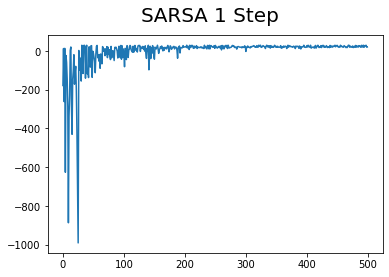

In [218]:
np.set_printoptions(suppress=True)
env = GridWorld("../grid.txt")
env.print_map()

time1, print_policy, all_reward = sarsa_run(1)
print("\n\nSARSA: 1 Step      Time: " + str(time1) + " seconds")
print("0: Hole    1: Left    2: Right    3: Up    4: Down    9: Goal")
print(print_policy)
fig = plt.figure()
plt.plot(all_reward)
fig.suptitle('SARSA 1 Step', fontsize=20)
print(all_reward[-1])



SARSA: 4 Step      Time: 0.8279018402099609 seconds
0: Hole    1: Left    2: Right    3: Up    4: Down    9: Goal
[[2. 4. 4. 0. 2. 2. 2. 4. 4.]
 [2. 4. 4. 0. 3. 1. 0. 4. 4.]
 [2. 2. 4. 4. 1. 1. 0. 4. 1.]
 [2. 2. 2. 4. 0. 0. 0. 4. 1.]
 [3. 3. 0. 4. 2. 4. 4. 4. 0.]
 [2. 4. 0. 2. 2. 2. 9. 1. 1.]
 [2. 2. 2. 2. 2. 2. 3. 1. 1.]]
22


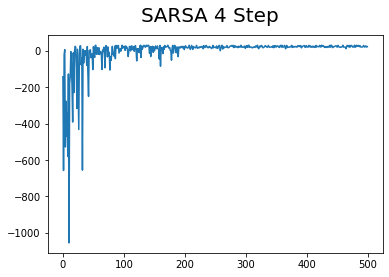

In [167]:
time4, print_policy, all_reward = sarsa_run(4)
print("\n\nSARSA: 4 Step      Time: " + str(time4) + " seconds")
print("0: Hole    1: Left    2: Right    3: Up    4: Down    9: Goal")
print(print_policy)
fig = plt.figure()
plt.plot(all_reward)
fig.suptitle('SARSA 4 Step', fontsize=20)
print(all_reward[-1])



SARSA: 8 Step      Time: 0.9219000339508057 seconds
0: Hole    1: Left    2: Right    3: Up    4: Down    9: Goal
[[2. 4. 4. 0. 4. 2. 2. 4. 4.]
 [2. 4. 4. 0. 4. 4. 0. 4. 1.]
 [2. 4. 2. 4. 1. 1. 0. 4. 1.]
 [2. 2. 2. 4. 0. 0. 0. 4. 1.]
 [3. 3. 0. 2. 2. 2. 4. 4. 0.]
 [3. 3. 0. 2. 2. 2. 9. 1. 1.]
 [3. 3. 2. 2. 2. 2. 3. 3. 1.]]
22


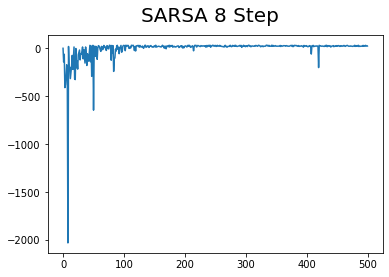

In [166]:
time8, print_policy, all_reward = sarsa_run(8)
print("\n\nSARSA: 8 Step      Time: " + str(time8) + " seconds")
print("0: Hole    1: Left    2: Right    3: Up    4: Down    9: Goal")
print(print_policy)
fig = plt.figure()
plt.plot(all_reward)
fig.suptitle('SARSA 8 Step', fontsize=20)
print(all_reward[-1])

NOTE: For plots, X axis is episodes, and Y axis is cumulative reward for that episode.

For n-step SARSA, results can be seen above. Each is run for 500 episodes. 1-step SARSA has a slightly faster execution time than the others; however, it also has a slightly lower final reward (21 compared to 22). This makes sense, as less steps means less computation looking forward. And with less forward view, 1-step SARSA doesn't get as much information about the environment per step. Therefore, for the same amount of steps, it doesn't converge as fast as the others. 4-step and 8-step perform very similiar. This is likely because the episodes are usually pretty short in this small grid world environment. Therefore, 8-step does not really provide an advantage over 4-step in this case.

# N-Step SARSA with Neural Network Function Approximation

In [96]:
#Functions in this block are based on the code found at: https://nbviewer.jupyter.org/url/webpages.uncc.edu/mlee173/teach/itcs6156/notebooks/notes/Note-NN%20for%20RL.ipynb
def network_init(lr):
    nHiddens = 20
    nSamples = 1
    nOutputs = 1
    nInputs = 4

    rhoh = rhoo = lr

    rh = rhoh / (nSamples*nOutputs)
    ro = rhoo / (nSamples*nOutputs)

    # Initialize weights to uniformly distributed values between small normally-distributed between -0.1 and 0.1
    V = 0.1*2*(np.random.uniform(size=(nInputs+1,nHiddens))-0.5)
    W = 0.1*2*(np.random.uniform(size=(1+nHiddens,nOutputs))-0.5)

    return rh, ro, V, W

def forward(X,V,W):
    #X = stdX.standardize(X)
    # Forward pass on training data
    X = (X-np.mean(X))/np.std(X)
    X1 = addOnes(X)
    Z = np.tanh(X1 @ V)
    Z1 = addOnes(Z)
    Y = Z1 @ W
    return Y, Z

def backward(error, Z, X,rh,ro,W):
    ### make sure the array shapes
    X = as_array(X)
    Z = as_array(Z)
    E = as_array(error)
    
    Z1 = addOnes(Z)
    X1 = addOnes(X)

    # Backward pass - the backpropagation and weight update steps
    dV = rh * X1.T @ ( ( E @ W[1:,:].T) * (1-Z**2))
    dW = ro * Z1.T @ E
    return dV, dW

def addOnes(A):
    return np.insert(A, 0, 1, axis=len(np.array(A).shape)-1)

def as_array(A):
    A = np.array(A)
    if len(A.shape) == 1:
        return A.reshape((1, -1))
    return A

def network_update(s,a,r1,s1,a1,gamma,V,W,rh,ro):
    a1buf = np.zeros((a1.shape[0],2))
    for idx in range(0,a1.shape[0]):
        a1buf[idx] = env._actions[a1[idx][0]]
    Q1, _ = forward(np.hstack((s1, a1buf)),V,W)  # output of neural network is Q for next state

    abuf = np.zeros((a.shape[0],2))
    for idx in range(0,a.shape[0]):
        abuf[idx] = env._actions[a[idx][0]]
    Q, Z = forward(np.hstack((s, abuf)),V,W)  # output of neural network is Q for next state

    error = r1 + gamma * Q1 - Q  # use action value as index by adding one
    dV, dW = backward(error, Z, np.hstack((s, abuf)),rh,ro,W)
    V += dV
    W += dW

def epsilon_greedy(e, s, V, W):
    if np.random.rand() < e:
        return np.random.randint(len(env._actions))
    else:
        all_actions = env._actions #grab all actions in action space
        Q, _ = forward(np.hstack((np.tile(s, (4,1)), all_actions)),V,W)
        max_as = np.where(Q == np.max(Q))[0] # index to action value
        return np.random.choice(max_as)

In [110]:
def sarsa_controlNFA(num_episodes,e=1, gamma=0.9, lr=0.1, n=1, batch_size=8):
    terminal_state_indicators = ["H","N","F","G"]
    epsilon = e
    final_epsilon = 0.1
    epsilon_decay =  np.exp(np.log(final_epsilon) / num_episodes)

    rh, ro, V, W = network_init(lr)
    all_Gt = []
    for ep in range(0, num_episodes):

        if(ep%100==0):
            print("Episode:  " + str(ep))
            #print_pol(V,W)

        episode = []
        start_row = random.randint(0,env._size[0])
        start_col = random.randint(0,env._size[1])
        if(env.check_state([start_row,start_col]) == 'O'):
            env.init([start_row,start_col])
        else:
            env.init([0,0])
        done = 0
        reward_sum = 0
        for steps in range(0,1000):
            state = env.get_cur_state()
            action = epsilon_greedy(epsilon, state, V, W)

            reward = env.next(action)
            #gather reward_sum for plotting
            reward_sum += reward
            next_state = env._s
            next_action = epsilon_greedy(epsilon, next_state, V, W)
            curr = env.check_state(next_state)
            if(curr in terminal_state_indicators):
                done = 1  
            #store experience
            episode.append((state, action, reward, next_state, next_action))
            #if done, break
            if done:
                break
            state = next_state
        all_Gt.append(reward_sum)

        #Early stopping
        if ep > 4:
            last = max(0,ep-2)
            if(mean(all_Gt[last:ep]) > reward_sum) and (reward_sum > 0):
                break

        step_count = 0
        G_t_lst = []
        for traj in episode:
            state = traj[0]
            action = traj[1]
            reward = traj[2]
            next_state = traj[3]
            next_action = traj[4]

            G_t = 0
            n_step = min(len(episode), step_count+n)
            for i in range(step_count, n_step):
                reward = episode[i][2]
                G_t += reward*(gamma**(i-step_count))
            G_t_lst.append(G_t)
            step_count += 1
        #prepare batch
        ep_arr = np.asarray(episode)
        b_size = batch_size
        for batch in range(math.ceil(len(ep_arr)/b_size)):
            place = batch*b_size
            limit = min(place+b_size, len(ep_arr))
            size = limit-place
            state_arr = np.concatenate(ep_arr[place:limit,0], axis=0).reshape(size,2).astype(np.int64)
            action_arr = ep_arr[place:limit,1].reshape(size,1).astype(np.int64)
            next_state_arr = np.concatenate(ep_arr[place:limit,3], axis=0).reshape(size,2).astype(np.int64)
            next_action_arr = ep_arr[place:limit,4].reshape(size,1).astype(np.int64)
            G_t_arr = np.asarray(G_t_lst[place:limit]).reshape(size,1).astype(np.int64)
            #run network update
            network_update(state_arr,action_arr,G_t_arr,next_state_arr,next_action_arr,(gamma**n),V,W,rh,ro)
        epsilon *= epsilon_decay
    return V,W, all_Gt

In [111]:
def print_pol(V,W):
    print_policy = np.zeros((env._size[0],env._size[1]))
    bad_state_indicators = ["H","N","F"]

    for row in range(0,env._size[0]):
        for col in range(0,env._size[1]):
            state = np.asarray([row,col])

            action_state_num = epsilon_greedy(0, state, V, W) + 1
            curr = env.check_state(state)
            if(curr in bad_state_indicators):
                print_policy[tuple(state)] = 0
            elif(curr in "G"):
                print_policy[tuple(state)] = 9
            else:
                print_policy[tuple(state)] = int(action_state_num)
    return print_policy

In [116]:
def sarsa_approx_run(steps):
    #******************* SARSA with Function Approximation ********************************
    start = time.time()
    V, W , all_rewards = sarsa_controlNFA(num_episodes=500, gamma=0.9, n=steps, lr=0.0002, batch_size=1000)
    end = time.time()
    print_policy = print_pol(V,W)
    total_time = end-start
    return print_policy, all_rewards, total_time

[['O' 'O' 'O' 'H' 'O' 'O' 'O' 'O' 'O']
 ['O' 'O' 'O' 'H' 'O' 'O' 'H' 'O' 'O']
 ['O' 'O' 'O' 'O' 'O' 'O' 'H' 'O' 'O']
 ['O' 'O' 'O' 'O' 'H' 'H' 'H' 'O' 'O']
 ['O' 'O' 'H' 'O' 'O' 'O' 'O' 'O' 'H']
 ['O' 'O' 'H' 'O' 'O' 'O' 'G' 'O' 'O']
 ['O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O']]
Episode:  0
Episode:  100
Episode:  200
Episode:  300


SARSA_NNFA: 1-Step      Time: 17.42008399963379 seconds
0: Hole    1: Left    2: Right    3: Up    4: Down    9: Goal
[[4. 4. 4. 0. 2. 2. 2. 2. 2.]
 [2. 4. 4. 0. 4. 4. 0. 4. 4.]
 [2. 2. 4. 4. 4. 4. 0. 4. 4.]
 [2. 2. 2. 4. 0. 0. 0. 4. 4.]
 [2. 2. 0. 2. 2. 4. 4. 1. 0.]
 [2. 2. 0. 2. 2. 2. 9. 4. 1.]
 [2. 2. 2. 2. 2. 2. 2. 4. 4.]]
Final episode reward: 24


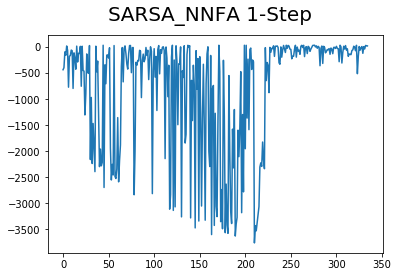

In [127]:
np.set_printoptions(suppress=True)
env = GridWorld("../grid.txt")
env.print_map()
from statistics import mean

print_policy, all_rewards, time1 = sarsa_approx_run(1)
print("\n\nSARSA_NNFA: 1-Step      Time: " + str(time1) + " seconds")
print("0: Hole    1: Left    2: Right    3: Up    4: Down    9: Goal")
print(print_policy)
fig = plt.figure()
plt.plot(all_rewards)
fig.suptitle('SARSA_NNFA 1-Step', fontsize=20)
print("Final episode reward: " + str(all_reward[-1]))

Episode:  0
Episode:  100


SARSA_NNFA: 4-Step      Time: 4.528754949569702 seconds
0: Hole    1: Left    2: Right    3: Up    4: Down    9: Goal
[[4. 4. 4. 0. 4. 4. 4. 4. 4.]
 [2. 2. 4. 0. 4. 4. 0. 4. 4.]
 [2. 2. 2. 4. 4. 4. 0. 4. 4.]
 [2. 2. 2. 2. 0. 0. 0. 4. 4.]
 [2. 2. 0. 2. 2. 2. 4. 4. 0.]
 [2. 2. 0. 2. 2. 2. 9. 4. 4.]
 [2. 2. 2. 2. 2. 2. 2. 2. 4.]]
Final episode reward: 24


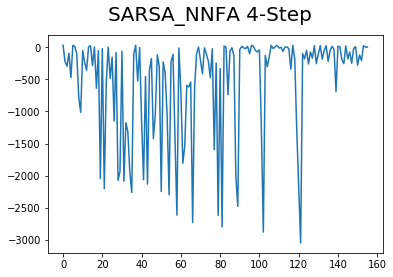

In [129]:
print_policy, all_rewards, time4 = sarsa_approx_run(4)
print("\n\nSARSA_NNFA: 4-Step      Time: " + str(time4) + " seconds")
print("0: Hole    1: Left    2: Right    3: Up    4: Down    9: Goal")
print(print_policy)
fig = plt.figure()
plt.plot(all_rewards)
fig.suptitle('SARSA_NNFA 4-Step', fontsize=20)
print("Final episode reward: " + str(all_reward[-1]))

Episode:  0
Episode:  100
Episode:  200


SARSA_NNFA: 8-Step      Time: 11.682741165161133 seconds
0: Hole    1: Left    2: Right    3: Up    4: Down    9: Goal
[[4. 4. 4. 0. 4. 4. 4. 4. 4.]
 [2. 4. 1. 0. 4. 4. 0. 4. 4.]
 [2. 2. 4. 1. 1. 4. 0. 4. 4.]
 [2. 2. 2. 4. 0. 0. 0. 4. 4.]
 [2. 2. 0. 2. 4. 1. 1. 1. 0.]
 [2. 2. 0. 2. 2. 4. 9. 1. 1.]
 [2. 2. 2. 2. 2. 2. 1. 1. 1.]]
Final episode reward: 24


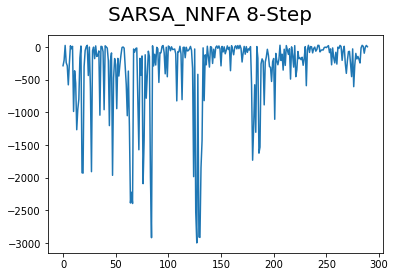

In [123]:
print_policy, all_rewards, time8 = sarsa_approx_run(8)
print("\n\nSARSA_NNFA: 8-Step      Time: " + str(time4) + " seconds")
print("0: Hole    1: Left    2: Right    3: Up    4: Down    9: Goal")
print(print_policy)
fig = plt.figure()
plt.plot(all_rewards)
fig.suptitle('SARSA_NNFA 8-Step', fontsize=20)
print("Final episode reward: " + str(all_reward[-1]))

NOTE: For plots, X axis is episodes, and Y axis is cumulative reward for that episode.

I tried the various modifications we discussed, including first-step implementation, increasing the neural network hidden layer size (5, 10, 20, 30, 50, and 100) and using the whole episode for each batch. I found that it worked best without first-step, a hidden size of 20, and using the entire episode for the batch (batch size=1000 because I have a maximum of 1000 steps per episode). However, even with these modifications, the model was not always stable. Once I plotted the reward charts, I could see that it typically did best before reaching the end of the episode limit. Therefore, I implemented early stopping to exit on a moderately useful policy. While not fully coverged, the polices at least have a general sense of moving towards the goal.

1-step SARSA_NNFA seemed to find a local minimum spot at approximately episode 350, settling its cumulative reward in the last 100 episodes. 8-step SARSA_NNFA found a similiar local minimum slighty earlier, at around 300 episodes. 4-step settled the quickest of all, finding a local minimum at around 160 episodes. As mentioned in the previous SARSA discussion above, 4-step seems to work the best in this grid world environment.

If you would like to look at my source code, it is on GitHub here: https://github.com/mmendiet/Reinforcement-Learning-Basics. If you have any other recommendations or realize why it is not fully converging, please feel free to let me know. Thank you!